## ``Stationarity``

A stationary time series is one whose statistical properties don't depend on the time on which series is observed.
i.e. A stationary time series doesn't have **seasonality** and **trends**.

In general, a stationary time series will have no predictable patterns in the long-term. Time plots will show the series to be roughly horizontal.

>**Trend** = When there is a long-term increase or decrease in the data 

>**Seasonality** = Reoccuring pattern at a fixed and known frequency based on a time of the year, week, or day
---
### ``Why is stationarity important?``

Time series should be stationary because, in the absence of stationarity the model describing the data will vary in accuracy at different points making it difficult to do forecasting. Hence, it is important for statistical properties such as mean, variances, correlation to stay stationary to the data at all points of interests.

<div class="alert alert-block alert-warning"><b>Note:</b> If the time series is not stationary <em>(which can be either found out by plotting the series or Augemented Dicky Fuller Test)</em>, convert it to stationary series using differencing.</div>

## ``Differencing``

Differencing is the transformation of time series to a new series where the values of new series are differences between the consecutive values of older series. This transformation can be applied **n** number of times where **n** is the order of differencing. 

<div class="alert alert-block alert-warning"><b>Note:</b> Transformations such as logarithms can help to stabilise the variance of a time series. Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


## ``Dataset``

- [X] Loading and Inspecting the datasets
- [X] Merging the confirmed, deaths and recovered datasets into single dataset and saving it.

In [3]:
confirmed_data = pd.read_csv('./time_series_covid19_confirmed_global.csv')
deaths_data = pd.read_csv('./time_series_covid19_deaths_global.csv')
recovered_data = pd.read_csv('./time_series_covid19_recovered_global.csv')

In [4]:
confirmed_data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,38641,38716,38772,38815,38855,38872,38883,38919,39044,39074
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,11185,11353,11520,11672,11816,11948,12073,12226,12385,12535
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,48007,48254,48496,48734,48966,49194,49413,49623,49826,50023
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,1344,1344,1438,1438,1483,1483,1564,1564,1564,1681
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,3335,3388,3439,3569,3675,3789,3848,3901,3991,4117


### Since time series is not in correct format we have to clean and organize dataset which can be consumed by the model.

Operation we will perform on the dataset...
 1. Rename the columns
 2. Drop the Province/State and Lat+Long columns of the dataset, we will forecast the data on country level, province and state is missing anyways.
 3. After removing the previous cols form the dataset, we need to add the duplicate rows which have same column values, this is done to make sure there is only one row for each country
 4. Swap the cols and rows, such that datetime will become the cols and will be set to index, deaths and country will be rows. <a id="duplicate"></a>
 
Example after 4th step

|Date    | Data| Country|
|- - - - | - - |- - - - |
|1/22/20 | 8987| India  |
|1/23/20 | 9000| China  |
 
After this our dataset will be much more suitable format for training our model

In [5]:
confirmed_data.rename(columns={'Province/State': 'State', 'Country/Region': 'Country'}, inplace=True)
deaths_data.rename(columns={'Province/State': 'State', 'Country/Region': 'Country'}, inplace=True)
recovered_data.rename(columns={'Province/State': 'State', 'Country/Region': 'Country'}, inplace=True)

In [6]:
confirmed_data.drop(['State', 'Lat', 'Long'], axis=1, inplace=True)
deaths_data.drop(['State', 'Lat', 'Long'], axis=1, inplace=True)
recovered_data.drop(['State', 'Lat', 'Long'], axis=1, inplace=True)

[Adding Duplicate Rows](#duplicate)

In [7]:
confirmed_data = confirmed_data.groupby('Country')[confirmed_data.columns[1:]].sum()
deaths_data = deaths_data.groupby('Country')[confirmed_data.columns[1:]].sum()
recovered_data = recovered_data.groupby('Country')[confirmed_data.columns[1:]].sum()

In [8]:
confirmed_data.head(2)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,38641,38716,38772,38815,38855,38872,38883,38919,39044,39074
Albania,0,0,0,0,0,0,0,0,0,0,...,11185,11353,11520,11672,11816,11948,12073,12226,12385,12535


In [9]:
confirmed_data = confirmed_data.reset_index() # converts original index to column value, helps in melting
confirmed_data = confirmed_data.melt(id_vars=['Country'] ,var_name="Date", value_name="confirmed")

deaths_data = deaths_data.reset_index()
deaths_data = deaths_data.melt(id_vars=['Country'] ,var_name="Date", value_name="deaths")

recovered_data = recovered_data.reset_index()
recovered_data = recovered_data.melt(id_vars=['Country'] ,var_name="Date", value_name="recovered")

In [10]:
confirmed_data.head(2)

,Country,Date,confirmed
0,Afghanistan,1/22/20,0
1,Albania,1/22/20,0


In [11]:
deaths_data.head(2)

,Country,Date,deaths
0,Afghanistan,1/23/20,0
1,Albania,1/23/20,0


In [12]:
recovered_data.head(2)

,Country,Date,recovered
0,Afghanistan,1/23/20,0
1,Albania,1/23/20,0


## ``Converting String Date to Datetime object and setting it to index``

In [13]:
confirmed_data['Date'] = pd.to_datetime(confirmed_data['Date'])
deaths_data['Date'] = pd.to_datetime(deaths_data['Date'])
recovered_data['Date'] = pd.to_datetime(recovered_data['Date'])

In [14]:
confirmed_data.head()

,Country,Date,confirmed
0,Afghanistan,2020-01-22,0
1,Albania,2020-01-22,0
2,Algeria,2020-01-22,0
3,Andorra,2020-01-22,0
4,Angola,2020-01-22,0


In [15]:
deaths_data.tail(5)

,Country,Date,deaths
45679,West Bank and Gaza,2020-09-21,265
45680,Western Sahara,2020-09-21,1
45681,Yemen,2020-09-21,586
45682,Zambia,2020-09-21,331
45683,Zimbabwe,2020-09-21,225


## ``Before Merging datasets`` 

<div class="alert alert-block alert-danger"><b>Danger:</b> The <b>confirmed_data</b> dataframe seems to have more rows than <b>deaths_data</b> and <b>recovered_data</b>, It is important to remove those, else when NaN values will appear when datasets are merged.</div>

Both deaths_data and recovered_data both have same numbers of rows, confirmed_data seems to have 188 extra rows.

To find which are those extra rows, take the Date column and create a set for it, this will allow only unique values and then subtract deaths_data Date column set from the confirmed_data column set to get the extra rows

In [16]:
set(confirmed_data.Date.unique()) - set(deaths_data.Date.unique()) # Extra Timestamp

{numpy.datetime64('2020-01-22T00:00:00.000000000')}

In [17]:
# there are 188 rows for this particular date, remove them and we are ready to merge the datasets
confirmed_data[confirmed_data['Date'] == pd.Timestamp(2020, 1, 22)]

,Country,Date,confirmed
0,Afghanistan,2020-01-22,0
1,Albania,2020-01-22,0
2,Algeria,2020-01-22,0
3,Andorra,2020-01-22,0
4,Angola,2020-01-22,0
...,...,...,...
183,West Bank and Gaza,2020-01-22,0
184,Western Sahara,2020-01-22,0
185,Yemen,2020-01-22,0
186,Zambia,2020-01-22,0


In [18]:
confirmed_data.Country.iloc[188]

'Afghanistan'

In [19]:
# Slice the extra rows
confirmed_data = confirmed_data.iloc[188:, :]

In [20]:
confirmed_data.shape

(45684, 3)

In [21]:
confirmed_data.head(2)

,Country,Date,confirmed
188,Afghanistan,2020-01-23,0
189,Albania,2020-01-23,0


In [22]:
confirmed_data.reset_index(inplace=True)
# resets the index again from 0.

## ``Finally Merging the dataset``

<div class="alert alert-block alert-danger"><b>Danger:</b> When Merging 3 datasets, it is important to remember that at least index should be unique, or else you can't really merge it. This is why the index is set as Date AFTER merging. Because Date and Country both have repeating values.</div>

In [23]:
data = confirmed_data
data['deaths'] = deaths_data['deaths']
data['recovered'] = recovered_data['recovered']

In [24]:
data.drop('index', axis=1, inplace=True)

In [25]:
data

,Country,Date,confirmed,deaths,recovered
0,Afghanistan,2020-01-23,0,0,0
1,Albania,2020-01-23,0,0,0
2,Algeria,2020-01-23,0,0,0
3,Andorra,2020-01-23,0,0,0
4,Angola,2020-01-23,0,0,0
...,...,...,...,...,...
45679,West Bank and Gaza,2020-09-21,36151,265,24428
45680,Western Sahara,2020-09-21,10,1,8
45681,Yemen,2020-09-21,2028,586,1235
45682,Zambia,2020-09-21,14175,331,13629


In [26]:
data.set_index('Date', inplace=True)

In [27]:
data.index = pd.DatetimeIndex(data.index).to_period('M')

<div class="alert alert-block alert-success"><b>Success:</b> DataSet is completely clean and ready to use, storing the dataset for future use.</div>

In [28]:
data.to_csv('final_merged_covid_time_series.csv')

## ``Visualization``

<div class="alert alert-block alert-warning"><b>Note:</b> below given subplots are all line plot, since the data is so condensed they may not appear to be line plots, zoom in to get much better view. Also their scales are different.</div>

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabe

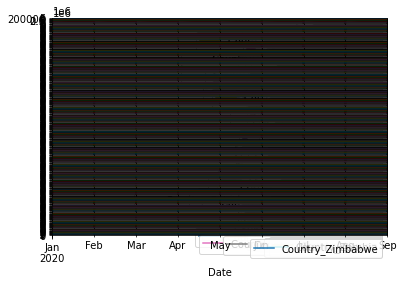

In [53]:
data.plot(subplots=True, grid=True)

<IPython.core.display.Javascript object>


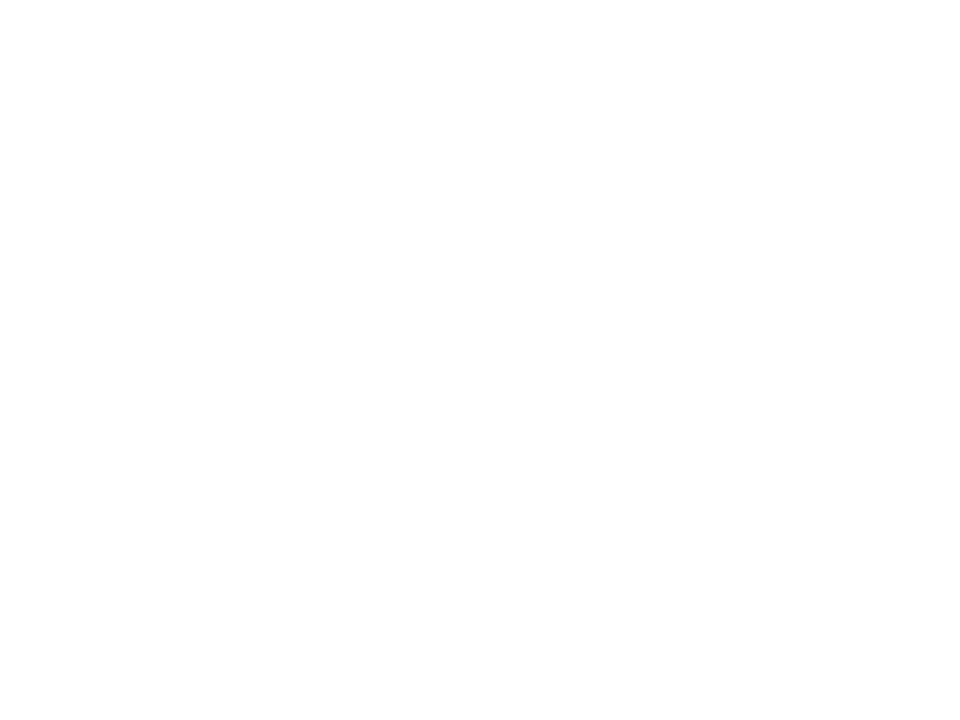

array([<AxesSubplot:xlabel='Date'>], dtype=object)

In [30]:
data.loc[:, ['confirmed']].plot(subplots=True, grid=True)

## <u>Performing Adfuller test

 In the ADF test, there is a null hypothesis for which the time series is considered as non-stationary. So, if the p-value of the test is less than the significance level then it rejects the null hypothesis and considers that the time series is stationary.

If the time series is not stationary, it is needed to differentiate the time series when training the model and invert the predicted values to get the real forecast by the number of times differentiated.

In [31]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

In [32]:
def adfuller_test(time_series_):
    """
    A wrapper function to perform adfuller test for all the cols.
    """
    data_cols = time_series_.columns[1:].tolist()
    
    for col in data_cols:
        test = adfuller(time_series_[col], autolag='AIC')
        print(f"Column Name: {col}")
        print(f"ADF test statistic: {test[0]}")
        print(f"p-value: {test[1]}")
        if test[1] > 0.05:
            print("Not Stationary")
        else:
            print("Stationary")
        print("---------------------------------")

In [33]:
adfuller_test(data)
# Ad fuller test before differencing

Column Name: confirmed
ADF test statistic: -13.155685077662012
p-value: 1.3387920666766263e-24
Stationary
---------------------------------
Column Name: deaths
ADF test statistic: -16.528855910886396
p-value: 2.0322672444289498e-29
Stationary
---------------------------------
Column Name: recovered
ADF test statistic: -10.538422325154817
p-value: 8.77738874244281e-19
Stationary
---------------------------------


## If the p value is less than 0.05 then it is considered stationary.


## Train Test Split

In [34]:
data = pd.get_dummies(data, columns=['Country'])

In [35]:
# taking last 10 rows for testing data
train = data.iloc[:-10, :] 
test = data.iloc[-10:, :]

In [36]:
train.head()

,confirmed,deaths,recovered,Country_Afghanistan,Country_Albania,Country_Algeria,Country_Andorra,Country_Angola,Country_Antigua and Barbuda,Country_Argentina,...,Country_United Kingdom,Country_Uruguay,Country_Uzbekistan,Country_Venezuela,Country_Vietnam,Country_West Bank and Gaza,Country_Western Sahara,Country_Yemen,Country_Zambia,Country_Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-01,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Training the Model
---
### Searching the optimal order for VAR model

Using AIC we can select the order of VAR based on the best AIC score. We are looking for a inflection point, firstly AIC score should decrease with lag order increasing and then AIC score will start to drop again. 

Optimal order can be found out by technique called grid search

In [37]:
model = VAR(train)

In [38]:
# results_aic = []
# for lag_order in range(1,10):
#     results = model.fit(lag_order)
#    results_aic.append(results.aic)

In [39]:
# import seaborn as sns
# %matplotlib inline
# sns.set()
# plt.plot(list(np.arange(1,10,1)), results_aic)
# plt.xlabel("Order")
# plt.ylabel("AIC")
# plt.show()

## The lowest AIC score achieved is at lag order 1, after which it starts to increase

In [40]:
results = model.fit(1)

In [41]:
# results.summary()

In [42]:
lagged_values = train.values[-1:]
# using last 1 value as lagged valyes and steps set to 10

In [43]:
lagged_values.shape

(1, 191)

In [44]:
test
# this is last value in train 

,confirmed,deaths,recovered,Country_Afghanistan,Country_Albania,Country_Algeria,Country_Andorra,Country_Angola,Country_Antigua and Barbuda,Country_Argentina,...,Country_United Kingdom,Country_Uruguay,Country_Uzbekistan,Country_Venezuela,Country_Vietnam,Country_West Bank and Gaza,Country_Western Sahara,Country_Yemen,Country_Zambia,Country_Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-09,401122,41877,2228,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2020-09,1927,46,1634,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2020-09,52070,437,48369,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2020-09,67443,555,56726,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2020-09,1068,35,947,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2020-09,36151,265,24428,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2020-09,10,1,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2020-09,2028,586,1235,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2020-09,14175,331,13629,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [45]:
forecast = pd.DataFrame(
    results.forecast(y=lagged_values, steps=10), index = test.index, columns = train.columns.tolist())

forecast

,confirmed,deaths,recovered,Country_Afghanistan,Country_Albania,Country_Algeria,Country_Andorra,Country_Angola,Country_Antigua and Barbuda,Country_Argentina,...,Country_United Kingdom,Country_Uruguay,Country_Uzbekistan,Country_Venezuela,Country_Vietnam,Country_West Bank and Gaza,Country_Western Sahara,Country_Yemen,Country_Zambia,Country_Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-09,192750.563602,25315.249259,3870.098539,1.846613e-15,-2.149853e-12,-1.633026e-12,2.910843e-12,2.359736e-13,3.415266e-12,-1.499968e-12,...,1.000000e+00,-3.998538e-16,3.747003e-16,-4.605691e-16,-1.214306e-16,1.077263e-15,-7.329207e-16,-9.445569e-16,-2.202231e-15,8.465451e-16
2020-09,892.514669,24.528186,684.628458,-4.614364e-16,-4.808653e-15,-2.153869e-12,-1.628318e-12,2.911154e-12,2.424493e-13,3.411734e-12,...,2.269539e-14,1.000000e+00,-1.588139e-15,-4.675080e-16,-1.364360e-15,-1.012211e-15,4.085274e-16,-1.241195e-15,-1.166602e-15,-3.753942e-15
2020-09,11417.711964,75.371604,9200.867308,-2.009677e-15,6.439068e-13,3.150258e-13,-2.795083e-12,-2.057345e-12,2.156972e-12,5.583823e-13,...,-5.121971e-13,2.300677e-14,1.000000e+00,-1.301910e-15,-8.994541e-16,-8.239937e-17,-1.379105e-15,4.779163e-16,-3.234392e-15,6.852158e-17
2020-09,11000.668311,93.644648,7631.644048,7.464515e-15,1.280855e-12,1.629207e-12,-1.438978e-12,-2.914786e-12,-4.117656e-12,3.059857e-12,...,1.086891e-14,-5.131303e-13,2.426531e-14,1.000000e+00,-3.191891e-15,3.231790e-15,-3.870168e-15,-3.092145e-15,-8.012688e-15,2.789435e-15
2020-09,379.695517,5.529248,277.509394,-4.322064e-15,7.792422e-12,7.119048e-12,-8.796873e-12,-2.438786e-12,-1.514504e-11,1.254288e-12,...,-3.478624e-13,1.021492e-14,-5.187196e-13,2.686046e-14,1.000000e+00,-9.321537e-15,9.255617e-15,-1.019150e-15,1.096779e-14,-1.704539e-14
2020-09,5715.421839,38.586789,3206.227470,-1.788847e-14,-3.047938e-12,5.601318e-12,1.107987e-11,-8.205342e-12,2.211827e-12,-1.717211e-11,...,7.286532e-13,-3.483316e-13,1.023921e-14,-5.187430e-13,2.710679e-14,1.000000e+00,-9.854964e-15,9.742207e-15,-5.802650e-16,1.125315e-14
2020-09,5.995869,0.487604,4.495868,-1.210837e-15,-5.449369e-12,-7.086893e-12,1.282967e-11,1.185074e-11,2.740612e-13,-1.509088e-12,...,2.758430e-12,7.285622e-13,-3.577061e-13,1.277711e-14,-5.133732e-13,1.612859e-14,1.000000e+00,-4.443494e-15,3.322516e-14,-1.501230e-14
2020-09,709.450413,197.285124,340.033048,-1.806801e-14,3.644880e-13,-5.129949e-12,-7.640976e-12,1.287536e-11,1.119829e-11,5.613374e-13,...,-1.121426e-12,2.758628e-12,7.283861e-13,-3.566574e-13,1.229312e-14,-5.159892e-13,1.625436e-14,1.000000e+00,-3.511948e-15,3.352266e-14
2020-09,2924.057840,70.280992,2456.082636,4.339758e-14,-3.802427e-13,5.938045e-14,-4.596632e-12,-7.662135e-12,1.350287e-11,1.092249e-11,...,1.567236e-13,-1.121933e-12,2.765482e-12,7.258725e-13,-3.598354e-13,2.083837e-14,-5.254026e-13,1.105886e-14,1.000000e+00,5.811324e-15


In [46]:
## Visualizing Predictions

In [47]:
predicted_vs_test = forecast.iloc[:, 0:3].copy()

In [48]:
predicted_vs_test['confirmed_actual'], predicted_vs_test['deaths_actual'], predicted_vs_test['recovered_actual'] = test['confirmed'], test['deaths'], test['recovered']

In [49]:
predicted_vs_test

,confirmed,deaths,recovered,confirmed_actual,deaths_actual,recovered_actual
Date,,,,,,
2020-09,192750.563602,25315.249259,3870.098539,401122,41877,2228
2020-09,892.514669,24.528186,684.628458,1927,46,1634
2020-09,11417.711964,75.371604,9200.867308,52070,437,48369
2020-09,11000.668311,93.644648,7631.644048,67443,555,56726
2020-09,379.695517,5.529248,277.509394,1068,35,947
2020-09,5715.421839,38.586789,3206.227470,36151,265,24428
2020-09,5.995869,0.487604,4.495868,10,1,8
2020-09,709.450413,197.285124,340.033048,2028,586,1235
2020-09,2924.057840,70.280992,2456.082636,14175,331,13629


In [50]:

predicted_vs_test['confirmed'] = predicted_vs_test['confirmed'].astype(np.int64)
predicted_vs_test['deaths'] = predicted_vs_test['deaths'].astype(np.int64)
predicted_vs_test['recovered'] = predicted_vs_test['recovered'].astype(np.int64)

In [51]:
predicted_vs_test.reset_index(drop=True, inplace=True)

array([<AxesSubplot:xlabel='Sept 2020'>, <AxesSubplot:xlabel='Sept 2020'>,
       <AxesSubplot:xlabel='Sept 2020'>, <AxesSubplot:xlabel='Sept 2020'>,
       <AxesSubplot:xlabel='Sept 2020'>, <AxesSubplot:xlabel='Sept 2020'>],
      dtype=object)

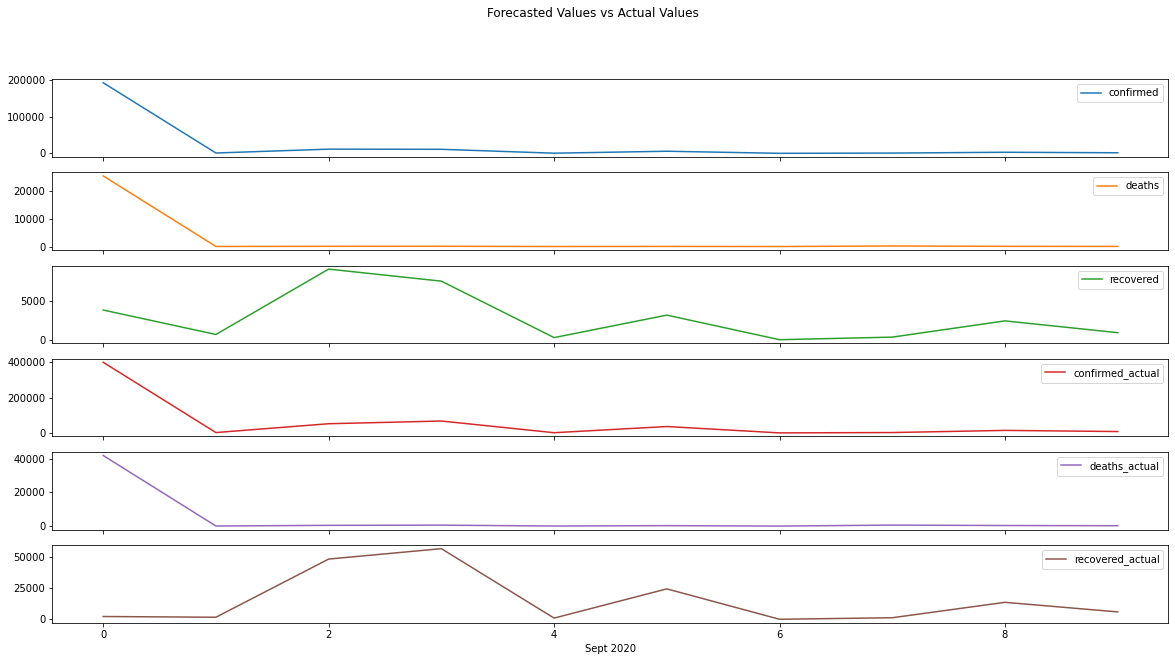

In [52]:
%matplotlib inline
predicted_vs_test.plot(figsize=(20, 10), subplots=True, title='Forecasted Values vs Actual Values', xlabel = "Sept 2020")